In [119]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from statsmodels.tools.tools import add_constant

In [9]:
%%bash
# (70s)
3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 56 1.25 \
    -num_stimts 1 \
    -stim_times 1 '1D: 2 17 25 40 55' 'GAM(8.6,.547,1)' \
    -x1D glm_regressor.1D


3dDeconvolve -overwrite -x1D_stop -polort -1 -nodata 56 1.25 \
    -num_stimts 1 \
    -stim_times_IM 1 '1D: 2 17 25 40 55' 'GAM(8.6,.547,1)' \
    -x1D glm_regressor_IM.1D

++ waveform setup: GAM(p=8.6,q=0.547,dur=1)
*+ WARNING: no -stim_label given for stim #1 ==> label = 'Stim#1'
++ 3dDeconvolve: AFNI version=AFNI_20.1.00 (Apr  9 2020) [64-bit]
++ Authored by: B. Douglas Ward, et al.
++ using TR=1.25 seconds for -stim_times and -nodata
++ using NT=56 time points for -nodata
++ -stim_times using TR=1.25 s for stimulus timing conversion
++ -stim_times using TR=1.25 s for any -iresp output datasets
++  [you can alter the -iresp TR via the -TR_times option]
++ ** -stim_times NOTE ** guessing GLOBAL times if 1 time per line; LOCAL otherwise
++ ** GUESSED ** -stim_times 1 using LOCAL times
++ Number of time points: 56 (no censoring)
 + Number of parameters:  1 [0 baseline ; 1 signal]
++ Wrote matrix values to file glm_regressor.1D
++ ----- Signal+Baseline matrix condition [X] (56x1):  1  ++ VERY GOOD ++
++ ----- Signal-only matrix condition [X] (56x1):  1  ++ VERY GOOD ++
++ 3dDeconvolve exits: -x1D_stop option was invoked
++ waveform setup: GAM(p=8.6,q=0.547

In [11]:
MR_reg = np.loadtxt('glm_regressor.1D')
IM_reg = np.loadtxt('glm_regressor_IM.1D')

In [41]:
np.random.seed(42)
noise = np.random.normal(0,0.2,MR_reg.size)
raw = noise + MR_reg

# 1. GLM: Comparison of Average vs. Individually Modulated (IM) Response

Consider the following raw timeseries data which contains five events. 

The peaks for the five events are not very evident due to random noise in the data.

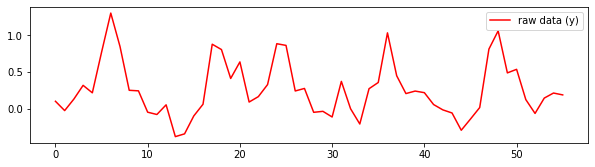

In [115]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='raw data (y)')
plt.legend()

## 1.1. Average response
Conventional approach to model the event responses is to specify a regressor with 5 events.

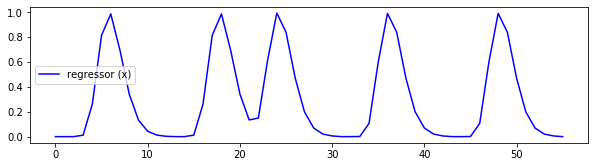

In [118]:
plt.figure(figsize=(10,2.5))
plt.plot(MR_reg,color='blue',label='regressor (x)')
plt.legend()

Notice all peaks have the same amplitude (= 1).

Now $x$ can be regressed on to the raw data ($y$) by running a simple linear regression model.

$$\hat{y_{i}} = \beta_{0} + \beta_{x}x_{i}$$

Where $\hat{y_{i}}$ is estimated response for the $i$th timepoint.


In [121]:
lm_MR = LinearRegression()
X_MR = add_constant(MR_reg)
lm_MR.fit(X_MR,raw)
y_hat_MR = lm_MR.predict(X_MR)

Following shows the estimated response ($\hat{y}$) overlaid in the raw data ($y$).

Notice the amplitude of all peaks in $\hat{y}$ is the same, however now scaled down to 0.95 from 1 (because it happens to provide the best fit).  
The 0.95 is the scaling factor ($\beta_{x}$ in the equation above) for the regressor $x$.


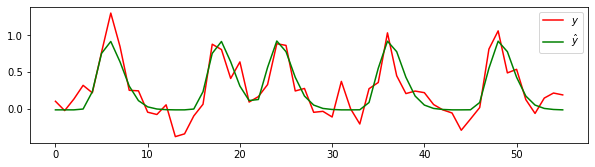

In [150]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$')
plt.plot(y_hat_MR,color='green',label=r'$\hat{y}$')
plt.legend()

## 1.2. Individually modulated (IM) response

Now instead of using single regressor to model 5 events, lets use separate regressors to model each event.

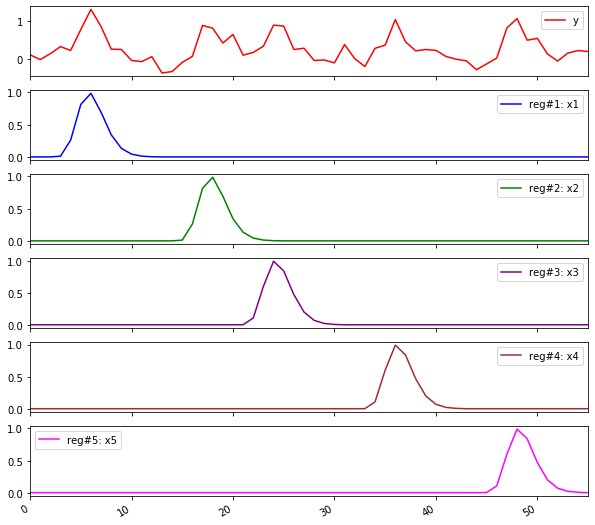

In [152]:
_=pd.DataFrame(np.hstack((raw[:,None],IM_reg)),
               columns=['y']+['reg#%i: x%i' %(i,i) for i in range(1,6)]).plot(subplots=True,
                                                                       color=['red','blue','green','purple','brown','magenta'],
                                                                       figsize=(10,10))

Notice again, peaks of all 5 regressors have the same amplitude (= 1).

The $x1$, $x2$, $x3$, $x4$, and $x5$ can be regressed on to the raw data ($y$) by running a multiple linear regression model.

$$\hat{y_{i}} = \beta_{0} + \beta_{x1}x1_{i} + + \beta_{x2}x2_{i} + \beta_{x3}x3_{i}+ \beta_{x4}x4_{i}+ \beta_{x5}x5_{i}$$

Where $\hat{y_{i}}$ is estimated response for $i$th timepoint.

In [141]:
lm_IM = LinearRegression()
X_IM = add_constant(IM_reg)
lm_IM.fit(X_IM,raw)
y_hat_IM = lm_IM.predict(X_IM)

Notice the peaks in $\hat{y}$ have acquired different amplitudes in order to approximate the raw data.  

That is, each regressor is now scaled by a different $\beta_{x_{n}}$, where n = 1,2,3,4,5.

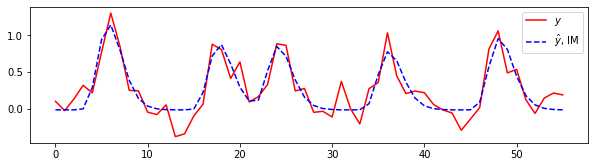

In [153]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$')
plt.plot(y_hat_IM,color='blue',label=r'$\hat{y}$, IM',linestyle='--')
plt.legend()

## 1.3. Visualize fits from both methods

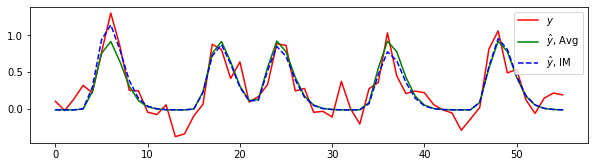

In [155]:
plt.figure(figsize=(10,2.5))
plt.plot(raw,color='red',label='$y$')
plt.plot(y_hat_MR,color='green',label=r'$\hat{y}$, Avg')
plt.plot(y_hat_IM,color='blue',label=r'$\hat{y}$, IM',linestyle='--')
plt.legend()